In [1]:
import tensorflow as tf

from keras import optimizers
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications import ResNet50, DenseNet201
from keras.applications import resnet, densenet

import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import pandas as pd
!pip install split-folders

In [2]:
path="/kaggle/input/combined-project-data/Data"

In [3]:
import splitfolders
splitfolders.ratio(path, output="/kaggle/working/", 
                   seed=1, ratio=(.8,.2), 
                   group_prefix=None,)

Copying files: 900 files [00:07, 125.00 files/s]


In [4]:
class_labels=['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma']

In [5]:
def prepare_name_with_labels(folder_name,Y, dataset_type='train'):
    """ Prepare the file names (X) and the class labels (Y) from folder location of images.

        Args:
            folder_name: str
                Source folder's path

    """
#     Y=[]
    source_files = os.listdir(os.path.join("/kaggle/working/", dataset_type, folder_name))
    y_label = 0
    for i in range(len(class_labels)):
        if(folder_name == class_labels[i]):
            y_label = i
    for val in source_files:
        Y.append(y_label)

In [6]:
def load_images_from_folder(X,folder,size=(224,224)):
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img=cv2.resize(img,size)
            X.append(img)
    print(len(X))

In [7]:
X=[]
for i in range(len(class_labels)):
    folder=os.path.join("/kaggle/working/train/"+class_labels[i])
    load_images_from_folder(X,folder)
#     X.append(image)
    print("\n",i)

260

 0
390

 1
517

 2
718

 3


In [8]:
Y=[]
for i in range(len(class_labels)):
    prepare_name_with_labels(class_labels[i],Y)
    print(i)

0
1
2
3


In [9]:
X_test=[]
for i in range(len(class_labels)):
    folder=os.path.join("/kaggle/working/val/"+class_labels[i])
    load_images_from_folder(X_test,folder)
#     X.append(image)
    print("\n",i)

66

 0
99

 1
131

 2
182

 3


In [10]:
Y_test=[]
for i in range(len(class_labels)):
    prepare_name_with_labels(class_labels[i],Y_test,dataset_type='val')
    print(i)

0
1
2
3


In [11]:
X = np.asarray(X)
Y = np.asarray(Y)
X_test=np.asarray(X_test)
Y_test=np.asarray(Y_test)
print(X.shape)
print(Y.shape)
print(X_test.shape)
print(Y_test.shape)

(718, 224, 224, 3)
(718,)
(182, 224, 224, 3)
(182,)


In [12]:
from sklearn.preprocessing import OneHotEncoder
drop_binary_enc = OneHotEncoder().fit(Y.reshape(-1,1))
Y_label=drop_binary_enc.transform(Y.reshape(-1,1)).toarray()
print(Y_label.shape)

(718, 4)


In [13]:
from sklearn.preprocessing import OneHotEncoder
drop_binary_enc_test = OneHotEncoder().fit(Y_test.reshape(-1,1))
Y_label_test=drop_binary_enc_test.transform(Y_test.reshape(-1,1)).toarray()
print(Y_label_test.shape)

(182, 4)


In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')
valid_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')
test_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')

In [15]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [16]:
image_shape = (224,224,3)
N_CLASSES = 4
BATCH_SIZE = 32
densenet121_model = tf.keras.applications.DenseNet121(include_top=False, input_shape=image_shape, weights="imagenet", classes=4)
    # Freeze the pretrained weights
densenet121_model.trainable =False

29084464/29084464 [==============================] - 1s 0us/step


In [17]:
early_stopping = EarlyStopping(verbose=1, patience=12)

In [18]:
def create_new_model(n):
    n=str(n)
    model = Sequential()
    model.add(densenet121_model)
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(N_CLASSES, activation='softmax'))
    model.compile(optimizer=optimizers.Adam(learning_rate= 0.0001, decay= 1e-5), loss = 'categorical_crossentropy', metrics = ['acc'])
    
    checkpointer = ModelCheckpoint(filepath='./densenet121_model'+n+'.hdf5',
                            monitor='val_acc', verbose = 1,
                            save_best_only=True)
    return model,checkpointer
#     "model"+n.summary()

Results for fold 1
Epoch 1/25


2023-04-18 08:03:33.691465: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.5102 - acc: 0.4024
Epoch 1: val_acc improved from -inf to 0.65278, saving model to ./densenet121_model1.hdf5
18/18 [==============================] - 15s 287ms/step - loss: 1.5102 - acc: 0.4024 - val_loss: 0.8789 - val_acc: 0.6528
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.8232 - acc: 0.6725
Epoch 2: val_acc improved from 0.65278 to 0.79167, saving model to ./densenet121_model1.hdf5
18/18 [==============================] - 2s 126ms/step - loss: 0.8232 - acc: 0.6725 - val_loss: 0.6683 - val_acc: 0.7917
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.5941 - acc: 0.7875
Epoch 3: val_acc improved from 0.79167 to 0.84722, saving model to ./densenet121_model1.hdf5
18/18 [==============================] - 2s 124ms/step - loss: 0.5941 - acc: 0.7875 - val_loss: 0.5758 - val_acc: 0.8472
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.4338 - acc: 0.8432
Epoch 4: val_ac

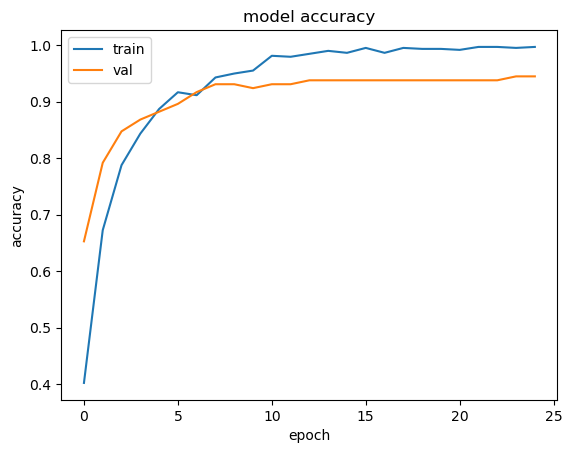

Model metrics for Round 1

6/6 [==============================] - 1s 136ms/step - loss: 0.2382 - acc: 0.9396
Accuracy 93.95604133605957
Loss 0.23823651671409607
Results for fold 2
Epoch 1/25


2023-04-18 08:04:37.551784: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.5175 - acc: 0.4094
Epoch 1: val_acc improved from -inf to 0.71528, saving model to ./densenet121_model2.hdf5
18/18 [==============================] - 10s 228ms/step - loss: 1.5175 - acc: 0.4094 - val_loss: 0.8209 - val_acc: 0.7153
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.8568 - acc: 0.6429
Epoch 2: val_acc improved from 0.71528 to 0.79861, saving model to ./densenet121_model2.hdf5
18/18 [==============================] - 2s 123ms/step - loss: 0.8568 - acc: 0.6429 - val_loss: 0.6295 - val_acc: 0.7986
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.6107 - acc: 0.7544
Epoch 3: val_acc improved from 0.79861 to 0.83333, saving model to ./densenet121_model2.hdf5
18/18 [==============================] - 2s 123ms/step - loss: 0.6107 - acc: 0.7544 - val_loss: 0.5312 - val_acc: 0.8333
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.4025 - acc: 0.8571
Epoch 4: val_ac

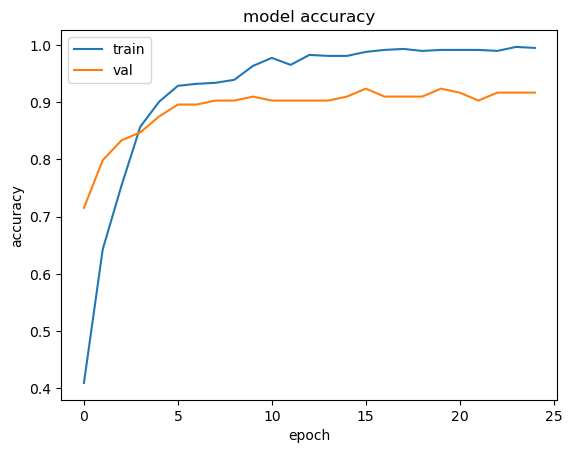

Model metrics for Round 2

6/6 [==============================] - 0s 64ms/step - loss: 0.2237 - acc: 0.9505
Accuracy 95.05494236946106
Loss 0.22371648252010345
Results for fold 3
Epoch 1/25


2023-04-18 08:05:34.130022: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.4674 - acc: 0.4199
Epoch 1: val_acc improved from -inf to 0.46528, saving model to ./densenet121_model3.hdf5
18/18 [==============================] - 10s 234ms/step - loss: 1.4674 - acc: 0.4199 - val_loss: 1.4583 - val_acc: 0.4653
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.9008 - acc: 0.6516
Epoch 2: val_acc improved from 0.46528 to 0.61111, saving model to ./densenet121_model3.hdf5
18/18 [==============================] - 3s 153ms/step - loss: 0.9008 - acc: 0.6516 - val_loss: 0.9732 - val_acc: 0.6111
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.6299 - acc: 0.7596
Epoch 3: val_acc improved from 0.61111 to 0.70833, saving model to ./densenet121_model3.hdf5
18/18 [==============================] - 2s 124ms/step - loss: 0.6299 - acc: 0.7596 - val_loss: 0.7277 - val_acc: 0.7083
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.4407 - acc: 0.8310
Epoch 4: val_ac

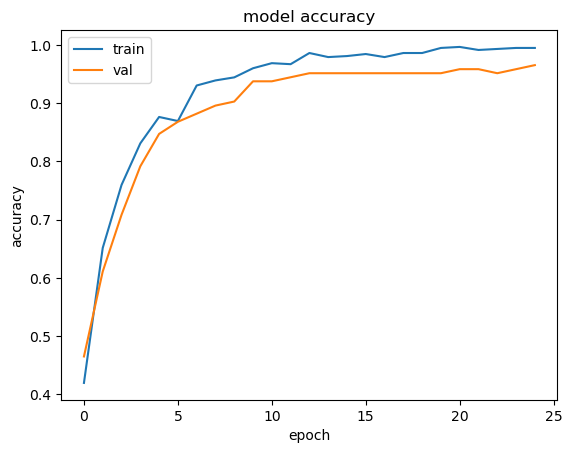

Model metrics for Round 3

6/6 [==============================] - 0s 62ms/step - loss: 0.2017 - acc: 0.9615
Accuracy 96.15384340286255
Loss 0.20165099203586578
Results for fold 4
Epoch 1/25


2023-04-18 08:06:35.143112: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.4846 - acc: 0.3913
Epoch 1: val_acc improved from -inf to 0.61538, saving model to ./densenet121_model4.hdf5
18/18 [==============================] - 11s 257ms/step - loss: 1.4846 - acc: 0.3913 - val_loss: 0.8094 - val_acc: 0.6154
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.8478 - acc: 0.6383
Epoch 2: val_acc improved from 0.61538 to 0.74825, saving model to ./densenet121_model4.hdf5
18/18 [==============================] - 2s 124ms/step - loss: 0.8478 - acc: 0.6383 - val_loss: 0.6403 - val_acc: 0.7483
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.5960 - acc: 0.7704
Epoch 3: val_acc improved from 0.74825 to 0.76923, saving model to ./densenet121_model4.hdf5
18/18 [==============================] - 2s 124ms/step - loss: 0.5960 - acc: 0.7704 - val_loss: 0.5376 - val_acc: 0.7692
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.4230 - acc: 0.8400
Epoch 4: val_ac

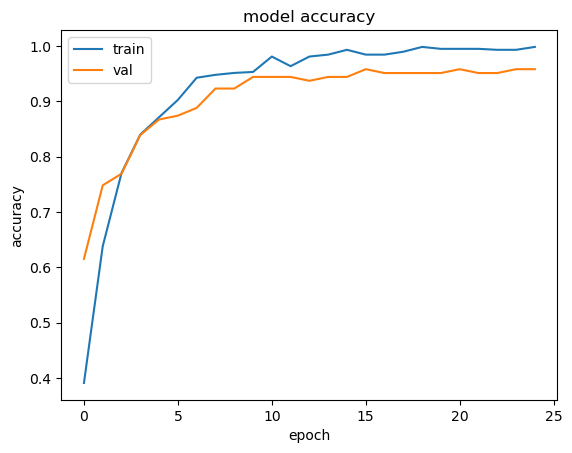

Model metrics for Round 4

6/6 [==============================] - 0s 63ms/step - loss: 0.2193 - acc: 0.9396
Accuracy 93.95604133605957
Loss 0.21931585669517517
Results for fold 5
Epoch 1/25


2023-04-18 08:07:33.645434: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.4326 - acc: 0.4243
Epoch 1: val_acc improved from -inf to 0.51049, saving model to ./densenet121_model5.hdf5
18/18 [==============================] - 11s 233ms/step - loss: 1.4326 - acc: 0.4243 - val_loss: 1.0648 - val_acc: 0.5105
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.8016 - acc: 0.6835
Epoch 2: val_acc improved from 0.51049 to 0.64336, saving model to ./densenet121_model5.hdf5
18/18 [==============================] - 2s 123ms/step - loss: 0.8016 - acc: 0.6835 - val_loss: 0.8162 - val_acc: 0.6434
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.5907 - acc: 0.7652
Epoch 3: val_acc improved from 0.64336 to 0.72727, saving model to ./densenet121_model5.hdf5
18/18 [==============================] - 2s 124ms/step - loss: 0.5907 - acc: 0.7652 - val_loss: 0.6660 - val_acc: 0.7273
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.4390 - acc: 0.8296
Epoch 4: val_ac

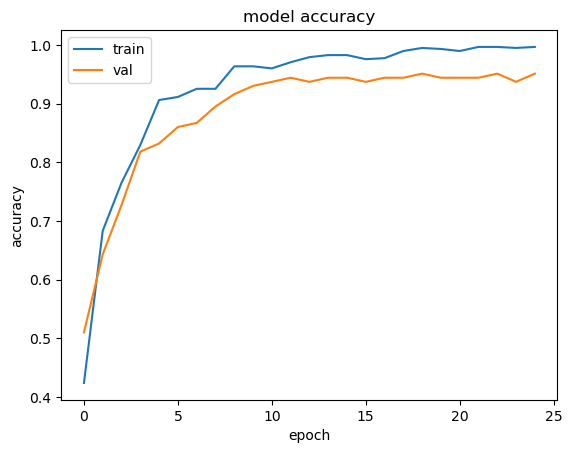

Model metrics for Round 5

6/6 [==============================] - 0s 62ms/step - loss: 0.2472 - acc: 0.9505
Accuracy 95.05494236946106
Loss 0.2472379058599472


In [19]:
fold_num = 0
skf_acc=[]
skf_loss=[]
for train_index, val_index in kfold.split(X, Y):
    # First cut all images from validation to train (if any exists)
#     transfer_all_class_between_folders('validation', 'train', 1.0)
    fold_num += 1
    print("Results for fold", fold_num)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y_label[train_index], Y_label[val_index]
#     print("\n",X_train.shape,Y_train.shape)
#     print(X_val.shape,Y_val.shape)
    train_generator = train_datagen.flow(X_train,
                                         Y_train,
                                         batch_size = BATCH_SIZE)
    valid_generator = valid_datagen.flow(X_val,
                                         Y_val,
                                         batch_size = BATCH_SIZE)
    test_generator = test_datagen.flow(X_test,
                                       Y_label_test,
                                       batch_size = BATCH_SIZE)

    model,checkpointer=create_new_model(fold_num)
    # fit model
    history= model.fit(train_generator,
                            epochs = 25,
                            verbose = 1,
                            validation_data = valid_generator,
                            callbacks = [checkpointer, early_stopping])
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    print("Model metrics for Round "+str(fold_num)+"\n")
    result= model.evaluate(test_generator)
    print("Accuracy",result[1]*100)
    print("Loss",result[0])
    skf_acc.append(result[1])
    skf_loss.append(result[0])

In [20]:
from sklearn.metrics import classification_report
target_names=class_labels
model2=tf.keras.models.load_model("/kaggle/working/densenet121_model3.hdf5")


In [21]:
model2.evaluate(test_generator)

6/6 [==============================] - 2s 65ms/step - loss: 0.2017 - acc: 0.9615


[0.20165102183818817, 0.9615384340286255]

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val=train_test_split(X,Y_label,train_size=0.8)

In [23]:
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(574, 224, 224, 3) (574, 4)
(144, 224, 224, 3) (144, 4)


Epoch 1/25


2023-04-18 08:11:10.619867: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.5172 - acc: 0.4059
Epoch 1: val_acc improved from -inf to 0.66667, saving model to ./densenet121_modelx.hdf5
18/18 [==============================] - 10s 248ms/step - loss: 1.5172 - acc: 0.4059 - val_loss: 0.7847 - val_acc: 0.6667
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.8644 - acc: 0.6551
Epoch 2: val_acc improved from 0.66667 to 0.77083, saving model to ./densenet121_modelx.hdf5
18/18 [==============================] - 2s 122ms/step - loss: 0.8644 - acc: 0.6551 - val_loss: 0.5760 - val_acc: 0.7708
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.6022 - acc: 0.7613
Epoch 3: val_acc improved from 0.77083 to 0.82639, saving model to ./densenet121_modelx.hdf5
18/18 [==============================] - 2s 122ms/step - loss: 0.6022 - acc: 0.7613 - val_loss: 0.4776 - val_acc: 0.8264
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.4106 - acc: 0.8519
Epoch 4: val_ac

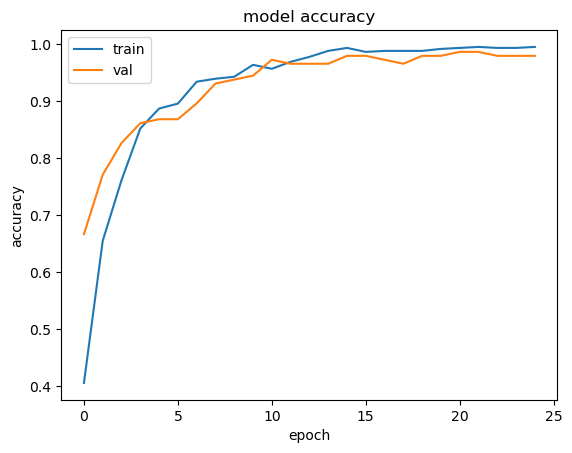

In [28]:
train_generator = train_datagen.flow(X_train,
                                         Y_train,
                                         batch_size = BATCH_SIZE)
valid_generator = valid_datagen.flow(X_val,
                                     Y_val,
                                     batch_size = BATCH_SIZE)
test_generator = test_datagen.flow(X_test,
                                   Y_label_test,
                                   batch_size = BATCH_SIZE)
#create a new model
model2,checkpointer=create_new_model('x')
# fit model
history= model2.fit(train_generator,
                        epochs = 25,
                        verbose = 1,
                        validation_data = valid_generator,
                        callbacks = [checkpointer, early_stopping])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
score=model2.evaluate(test_generator)
print("Accuracy",score[1]*100)
print("Loss",score[0])

6/6 [==============================] - 0s 60ms/step - loss: 0.2391 - acc: 0.9341
Accuracy 93.40659379959106
Loss 0.23909753561019897


In [30]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True,random_state=1)

Results for fold 1.1
Epoch 1/25


2023-04-18 08:12:10.580062: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.4711 - acc: 0.4338
Epoch 1: val_acc improved from -inf to 0.59028, saving model to ./densenet121_model1.1.hdf5
18/18 [==============================] - 10s 235ms/step - loss: 1.4711 - acc: 0.4338 - val_loss: 0.8582 - val_acc: 0.5903
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.8491 - acc: 0.6638
Epoch 2: val_acc improved from 0.59028 to 0.71528, saving model to ./densenet121_model1.1.hdf5
18/18 [==============================] - 2s 130ms/step - loss: 0.8491 - acc: 0.6638 - val_loss: 0.6317 - val_acc: 0.7153
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.5778 - acc: 0.7857
Epoch 3: val_acc improved from 0.71528 to 0.83333, saving model to ./densenet121_model1.1.hdf5
18/18 [==============================] - 2s 124ms/step - loss: 0.5778 - acc: 0.7857 - val_loss: 0.5163 - val_acc: 0.8333
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.4204 - acc: 0.8519
Epoch 4: 

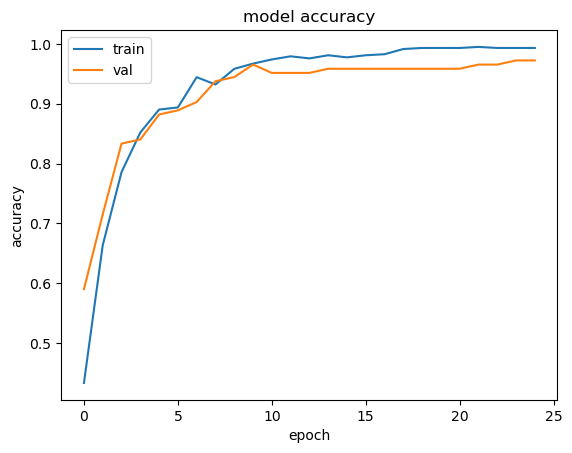

Model metrics for Round 1.1

6/6 [==============================] - 0s 62ms/step - loss: 0.2199 - acc: 0.9451
Accuracy:  94.50549483299255
Loss:  0.21989955008029938
Results for fold 2.1
Epoch 1/25


2023-04-18 08:13:08.106918: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.3851 - acc: 0.4164
Epoch 1: val_acc improved from -inf to 0.51389, saving model to ./densenet121_model2.1.hdf5
18/18 [==============================] - 10s 234ms/step - loss: 1.3851 - acc: 0.4164 - val_loss: 1.0470 - val_acc: 0.5139
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.8740 - acc: 0.6672
Epoch 2: val_acc improved from 0.51389 to 0.71528, saving model to ./densenet121_model2.1.hdf5
18/18 [==============================] - 2s 122ms/step - loss: 0.8740 - acc: 0.6672 - val_loss: 0.7366 - val_acc: 0.7153
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.5903 - acc: 0.7787
Epoch 3: val_acc improved from 0.71528 to 0.81944, saving model to ./densenet121_model2.1.hdf5
18/18 [==============================] - 2s 123ms/step - loss: 0.5903 - acc: 0.7787 - val_loss: 0.5642 - val_acc: 0.8194
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.3889 - acc: 0.8711
Epoch 4: 

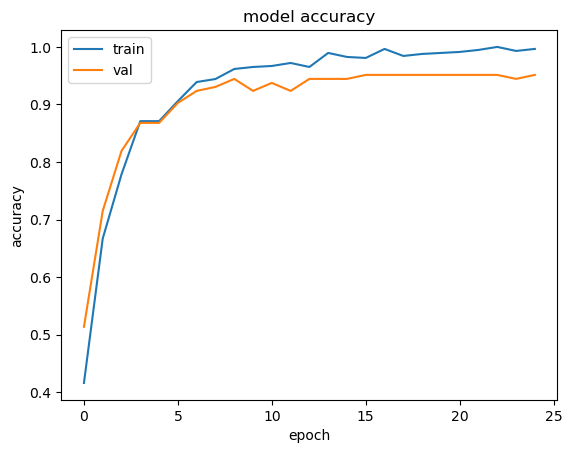

Model metrics for Round 2.1

6/6 [==============================] - 0s 62ms/step - loss: 0.2363 - acc: 0.9396
Accuracy:  93.95604133605957
Loss:  0.23627561330795288
Results for fold 3.1
Epoch 1/25


2023-04-18 08:14:05.871037: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.4211 - acc: 0.4286
Epoch 1: val_acc improved from -inf to 0.59028, saving model to ./densenet121_model3.1.hdf5
18/18 [==============================] - 10s 234ms/step - loss: 1.4211 - acc: 0.4286 - val_loss: 0.8728 - val_acc: 0.5903
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.8247 - acc: 0.6585
Epoch 2: val_acc improved from 0.59028 to 0.69444, saving model to ./densenet121_model3.1.hdf5
18/18 [==============================] - 2s 124ms/step - loss: 0.8247 - acc: 0.6585 - val_loss: 0.6903 - val_acc: 0.6944
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.5401 - acc: 0.7787
Epoch 3: val_acc improved from 0.69444 to 0.75694, saving model to ./densenet121_model3.1.hdf5
18/18 [==============================] - 2s 121ms/step - loss: 0.5401 - acc: 0.7787 - val_loss: 0.5820 - val_acc: 0.7569
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.4591 - acc: 0.8240
Epoch 4: 

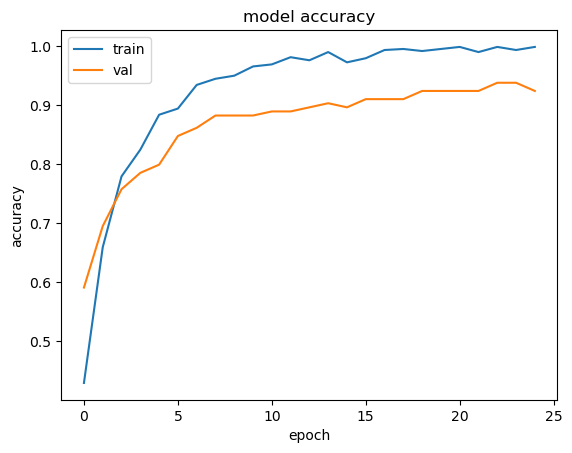

Model metrics for Round 3.1

6/6 [==============================] - 0s 63ms/step - loss: 0.2026 - acc: 0.9286
Accuracy:  92.85714030265808
Loss:  0.20256422460079193
Results for fold 4.1
Epoch 1/25


2023-04-18 08:15:07.412112: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.5355 - acc: 0.3878
Epoch 1: val_acc improved from -inf to 0.47552, saving model to ./densenet121_model4.1.hdf5
18/18 [==============================] - 10s 236ms/step - loss: 1.5355 - acc: 0.3878 - val_loss: 1.1995 - val_acc: 0.4755
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.8852 - acc: 0.6504
Epoch 2: val_acc improved from 0.47552 to 0.67133, saving model to ./densenet121_model4.1.hdf5
18/18 [==============================] - 2s 122ms/step - loss: 0.8852 - acc: 0.6504 - val_loss: 0.8259 - val_acc: 0.6713
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.5529 - acc: 0.7983
Epoch 3: val_acc improved from 0.67133 to 0.77622, saving model to ./densenet121_model4.1.hdf5
18/18 [==============================] - 2s 124ms/step - loss: 0.5529 - acc: 0.7983 - val_loss: 0.6372 - val_acc: 0.7762
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.4476 - acc: 0.8243
Epoch 4: 

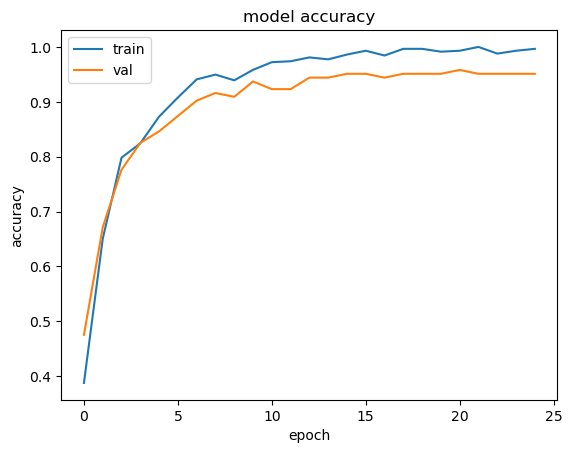

Model metrics for Round 4.1

6/6 [==============================] - 0s 62ms/step - loss: 0.2404 - acc: 0.9451
Accuracy:  94.50549483299255
Loss:  0.24040398001670837
Results for fold 5.1
Epoch 1/25


2023-04-18 08:16:08.210725: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_12/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.5130 - acc: 0.3791
Epoch 1: val_acc improved from -inf to 0.46853, saving model to ./densenet121_model5.1.hdf5
18/18 [==============================] - 10s 231ms/step - loss: 1.5130 - acc: 0.3791 - val_loss: 1.2522 - val_acc: 0.4685
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.9094 - acc: 0.6365
Epoch 2: val_acc improved from 0.46853 to 0.67133, saving model to ./densenet121_model5.1.hdf5
18/18 [==============================] - 2s 125ms/step - loss: 0.9094 - acc: 0.6365 - val_loss: 0.9170 - val_acc: 0.6713
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.6926 - acc: 0.7426
Epoch 3: val_acc improved from 0.67133 to 0.72727, saving model to ./densenet121_model5.1.hdf5
18/18 [==============================] - 2s 126ms/step - loss: 0.6926 - acc: 0.7426 - val_loss: 0.7396 - val_acc: 0.7273
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.4369 - acc: 0.8470
Epoch 4: 

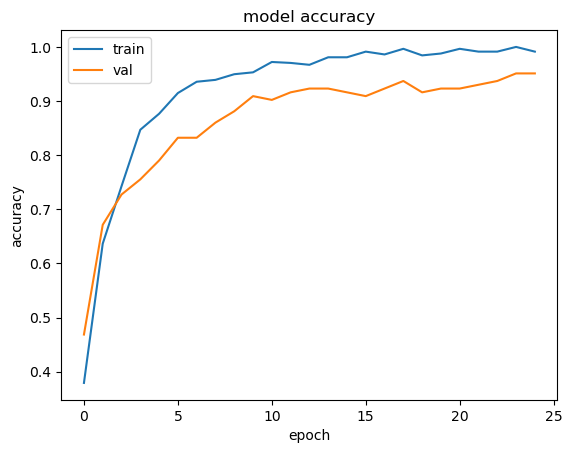

Model metrics for Round 5.1

6/6 [==============================] - 0s 60ms/step - loss: 0.2250 - acc: 0.9286
Accuracy:  92.85714030265808
Loss:  0.22501759231090546


In [31]:
fold_num = 0.1
kf_acc=[]
kf_loss=[]
for train_index, val_index in kf.split(X, Y_label):
    # First cut all images from validation to train (if any exists)
#     transfer_all_class_between_folders('validation', 'train', 1.0)
    fold_num += 1
    print("Results for fold", fold_num)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y_label[train_index], Y_label[val_index]
#     print("\n",X_train.shape,Y_train.shape)
#     print(X_val.shape,Y_val.shape)
    train_generator = train_datagen.flow(X_train,
                                         Y_train,
                                         batch_size = BATCH_SIZE)
    valid_generator = valid_datagen.flow(X_val,
                                         Y_val,
                                         batch_size = BATCH_SIZE)
    test_generator = test_datagen.flow(X_test,
                                       Y_label_test,
                                       batch_size = BATCH_SIZE)

    model,checkpointer=create_new_model(fold_num)
    # fit model
    history= model.fit(train_generator,
                            epochs = 25,
                            verbose = 1,
                            validation_data = valid_generator,
                            callbacks = [checkpointer, early_stopping])
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    print("Model metrics for Round "+str(fold_num)+"\n")
    result=model.evaluate(test_generator)
    print("Accuracy: ",result[1]*100)
    print("Loss: ",result[0])
    kf_acc.append(result[1])
    kf_loss.append(result[0])

In [32]:
skf_acc=np.array(skf_acc)
skf_loss=np.array(skf_loss)
kf_acc=np.array(kf_acc)
kf_loss=np.array(kf_loss)

print("Accuracy and loss for StratifiedKfold")
print("Accuracy: ",sum(skf_acc)/len(skf_acc)*100)
print("Loss: ",sum(skf_loss)/len(skf_loss))
print("\nAccuracy and loss for Kfold")
print("Accuracy: ",sum(kf_acc)/len(kf_acc)*100)
print("Loss: ",sum(kf_loss)/len(kf_loss))
print("\nAccuracy and loss for Holdout")
print("Accuracy: ",score[1]*100)
print("Loss: ",score[0])

Accuracy and loss for StratifiedKfold
Accuracy:  94.83516216278076
Loss:  0.22603155076503753

Accuracy and loss for Kfold
Accuracy:  93.73626232147217
Loss:  0.2248321920633316

Accuracy and loss for Holdout
Accuracy:  93.40659379959106
Loss:  0.23909753561019897
